### Preliminaries

This example shows both the use of individual transformers and the `TimeSeriesFeatures` convenience class that wraps multiple transformers. Both methods are compatible with Scikit-Learn `Pipeline` objects.

It uses the Macrodata dataset from `Statsmodels`, which includes quarterly US Macroeconomic Data from 1950 through 2009.

In [1]:
import pandas as pd
import statsmodels.datasets
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error

from tsfeast.transformers import DateTimeFeatures, InteractionFeatures
from tsfeast.tsfeatures import TimeSeriesFeatures
from tsfeast.utils import plot_diag

In [2]:
data = statsmodels.datasets.macrodata.load_pandas().data
data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


The only pre-processing necessary is to combined the separate `year` and `quarter` columns into a single `date` column:

In [3]:
dates = (
    data.iloc[:, :2]
    .apply(lambda x: x.astype(int).astype(str))
    .apply(lambda row: '-0'.join(row), axis=1)
)
data.drop(['year', 'quarter'], axis=1, inplace=True)
data.insert(loc=1, column='date', value=dates)
data

,realgdp,date,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,2710.349,1959-01,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,2778.801,1959-02,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,2775.488,1959-03,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,2785.204,1959-04,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,2847.699,1960-01,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,13324.600,2008-03,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,13141.920,2008-04,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,12925.410,2009-01,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,12901.504,2009-02,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [4]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
x_train, x_test = X.iloc[:-40, :], X.iloc[-40:, :]
y_train, y_test = y.iloc[:-40], y.iloc[-40:]

### Individual Transformers

#### Generate DateTime Features

In [5]:
dt = DateTimeFeatures(date_col='date')
dt.fit_transform(X, y)

,year,quarter,month,leap_year
0,1959,1,1,0
1,1959,1,2,0
2,1959,1,3,0
3,1959,2,4,0
4,1960,1,1,1
...,...,...,...,...
198,2008,1,3,1
199,2008,2,4,1
200,2009,1,1,0
201,2009,1,2,0


#### Generate Interaction Features

In [6]:
feat = InteractionFeatures()
feat.fit_transform(X.iloc[:, 1:], y)

,realcons:realinv,realcons:realgovt,realcons:realdpi,realcons:cpi,realcons:m1,realcons:tbilrate,realcons:unemp,realcons:pop,realcons:infl,realcons:realint,...,tbilrate:unemp,tbilrate:pop,tbilrate:infl,tbilrate:realint,unemp:pop,unemp:infl,unemp:realint,pop:infl,pop:realint,infl:realint
0,4.898496e+05,8.025548e+05,3221693.06,4.948045e+04,238523.78,4814.868,9902.92,3.024591e+05,0.000,0.000,...,16.356,499.55172,0.0000,0.0000,1027.4468,0.000,0.000,0.00000,0.00000,0.0000
1,5.389362e+05,8.344315e+05,3328183.89,5.053735e+04,245665.29,5339.796,8841.87,3.083039e+05,4056.858,1282.938,...,15.708,547.71640,7.2072,2.2792,906.9330,11.934,3.774,416.12220,131.59420,1.7316
2,5.066661e+05,8.605893e+05,3357149.52,5.141533e+04,246127.90,6691.876,9284.54,3.129713e+05,4799.932,1909.462,...,20.246,682.46974,10.4668,4.1638,946.8821,14.522,5.777,489.52018,194.73613,2.9866
3,5.249806e+05,8.488820e+05,3386920.81,5.150617e+04,245518.00,7593.521,9820.72,3.145892e+05,473.499,7120.022,...,24.248,776.74138,1.1691,17.5798,1004.5616,1.512,22.736,48.43422,728.30716,1.0962
4,5.873138e+05,8.183233e+05,3462212.75,5.230057e+04,247161.80,6196.750,9206.60,3.187024e+05,4089.855,2106.895,...,18.200,630.02450,8.0850,4.1650,936.0364,12.012,6.188,415.81617,214.20833,2.7489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,1.844915e+07,9.189397e+06,91178412.91,2.010062e+06,13667077.19,10843.209,55606.20,2.829151e+06,-29285.932,40129.141,...,7.020,357.16590,-3.6972,5.0661,1831.6200,-18.960,25.980,-964.65320,1321.81910,-13.6828
199,1.708175e+07,9.262177e+06,91221054.12,1.951004e+06,14496390.45,1103.436,63447.57,2.813320e+06,-80826.687,81930.123,...,0.828,36.71424,-1.0548,1.0692,2111.0688,-60.651,61.479,-2689.31808,2726.03232,-78.3189
200,1.435248e+07,9.175006e+06,91414202.88,1.958530e+06,14668413.76,2026.024,74594.52,2.823053e+06,8656.648,-6538.532,...,1.782,67.44034,0.2068,-0.1562,2483.0307,7.614,-5.751,288.15418,-217.64837,-0.6674
201,1.338541e+07,9.405199e+06,92602147.50,1.970756e+06,15194930.40,1654.020,84538.80,2.823100e+06,30966.930,-29312.910,...,1.656,55.30068,0.6066,-0.5742,2826.4792,31.004,-29.348,1035.35162,-980.05094,-10.7503


### TimeSeriesFeatures Class


In [7]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=2,
    rolling=[4],
    interactions=True
)
features = feat.fit_transform(X, y)

/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [8]:
features.head()

,trend,original__realcons,original__realinv,original__realgovt,original__realdpi,original__cpi,original__m1,original__tbilrate,original__unemp,original__pop,...,features__interactions__tbilrate:unemp,features__interactions__tbilrate:pop,features__interactions__tbilrate:infl,features__interactions__tbilrate:realint,features__interactions__unemp:pop,features__interactions__unemp:infl,features__interactions__unemp:realint,features__interactions__pop:infl,features__interactions__pop:realint,features__interactions__infl:realint
0,1.0,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,...,16.356,499.55172,0.0000,0.0000,1027.4468,0.000,0.000,0.00000,0.00000,0.0000
1,2.0,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,...,15.708,547.71640,7.2072,2.2792,906.9330,11.934,3.774,416.12220,131.59420,1.7316
2,3.0,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,...,20.246,682.46974,10.4668,4.1638,946.8821,14.522,5.777,489.52018,194.73613,2.9866
3,4.0,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,...,24.248,776.74138,1.1691,17.5798,1004.5616,1.512,22.736,48.43422,728.30716,1.0962
4,5.0,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,...,18.200,630.02450,8.0850,4.1650,936.0364,12.012,6.188,415.81617,214.20833,2.7489


In [9]:
[x for x in features.columns]

['trend',
 'original__realcons',
 'original__realinv',
 'original__realgovt',
 'original__realdpi',
 'original__cpi',
 'original__m1',
 'original__tbilrate',
 'original__unemp',
 'original__pop',
 'original__infl',
 'original__realint',
 'datetime__year',
 'datetime__quarter',
 'datetime__month',
 'datetime__leap_year',
 'features__lags__realcons_lag_1',
 'features__lags__realinv_lag_1',
 'features__lags__realgovt_lag_1',
 'features__lags__realdpi_lag_1',
 'features__lags__cpi_lag_1',
 'features__lags__m1_lag_1',
 'features__lags__tbilrate_lag_1',
 'features__lags__unemp_lag_1',
 'features__lags__pop_lag_1',
 'features__lags__infl_lag_1',
 'features__lags__realint_lag_1',
 'features__lags__realcons_lag_2',
 'features__lags__realinv_lag_2',
 'features__lags__realgovt_lag_2',
 'features__lags__realdpi_lag_2',
 'features__lags__cpi_lag_2',
 'features__lags__m1_lag_2',
 'features__lags__tbilrate_lag_2',
 'features__lags__unemp_lag_2',
 'features__lags__pop_lag_2',
 'features__lags__infl_la

In [19]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=2,
    rolling=[4],
    interactions=True
)

pl = Pipeline([
    ('feature_extraction', feat),
    ('feature_selection', SelectKBest(k=10)),
    ('regression', LinearRegression())
])

pl.fit(x_train, y_train)

/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


Pipeline(steps=[('feature_extraction',
                 TimeSeriesFeatures(datetime='date', lags=2, rolling=[4],
                                    trend='t')),
                ('feature_selection', SelectKBest()),
                ('regression', LinearRegression())])

In [32]:
pl.named_steps.feature_extraction.output_features_

,trend,original__realcons,original__realinv,original__realgovt,original__realdpi,original__cpi,original__m1,original__tbilrate,original__unemp,original__pop,...,features__interactions__tbilrate:unemp,features__interactions__tbilrate:pop,features__interactions__tbilrate:infl,features__interactions__tbilrate:realint,features__interactions__unemp:pop,features__interactions__unemp:infl,features__interactions__unemp:realint,features__interactions__pop:infl,features__interactions__pop:realint,features__interactions__infl:realint
0,1.0,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,...,16.356,499.55172,0.0000,0.0000,1027.4468,0.000,0.000,0.00000,0.00000,0.0000
1,2.0,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,...,15.708,547.71640,7.2072,2.2792,906.9330,11.934,3.774,416.12220,131.59420,1.7316
2,3.0,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,...,20.246,682.46974,10.4668,4.1638,946.8821,14.522,5.777,489.52018,194.73613,2.9866
3,4.0,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,...,24.248,776.74138,1.1691,17.5798,1004.5616,1.512,22.736,48.43422,728.30716,1.0962
4,5.0,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,...,18.200,630.02450,8.0850,4.1650,936.0364,12.012,6.188,415.81617,214.20833,2.7489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,159.0,6913.1,1700.071,681.472,7591.0,163.90,1086.0,4.49,4.5,277.003,...,20.205,1243.74347,7.6779,12.4822,1246.5135,7.695,12.510,473.67513,770.06834,4.7538
159,160.0,7019.1,1754.743,688.147,7646.5,164.70,1097.8,4.38,4.4,277.790,...,19.272,1216.72020,8.5410,10.6434,1222.2760,8.580,10.692,541.69050,675.02970,4.7385
160,161.0,7088.3,1809.993,683.601,7698.4,165.90,1101.9,4.39,4.3,278.451,...,18.877,1222.39989,12.7310,6.5411,1197.3393,12.470,6.407,807.50790,414.89199,4.3210
161,162.0,7199.9,1803.674,683.594,7716.0,166.70,1098.7,4.54,4.3,279.295,...,19.522,1267.99930,8.7168,11.8948,1200.9685,8.256,11.266,536.24640,731.75290,5.0304


In [28]:
pl.predict(x_test.iloc[1, :]).shape

(163,)

In [22]:
y_test.shape

(40,)

In [23]:
mean_squared_error(y_test, pl.predict(x_test))

ValueError: Found input variables with inconsistent numbers of samples: [40, 163]

In [12]:
new_features = pl.named_steps.feature_extraction.feature_names_
mask = pl.named_steps.feature_selection.get_support()
new_features[mask]

Index(['features__interactions__tbilrate:unemp',
       'features__interactions__tbilrate:pop',
       'features__interactions__tbilrate:infl',
       'features__interactions__tbilrate:realint',
       'features__interactions__unemp:pop',
       'features__interactions__unemp:infl',
       'features__interactions__unemp:realint',
       'features__interactions__pop:infl',
       'features__interactions__pop:realint',
       'features__interactions__infl:realint'],
      dtype='object')

In [13]:
lr = LinearRegression()
lr.fit(X.iloc[:, 1:], y)
lr.score(X.iloc[:, 1:], y)

0.9998809084148669

/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


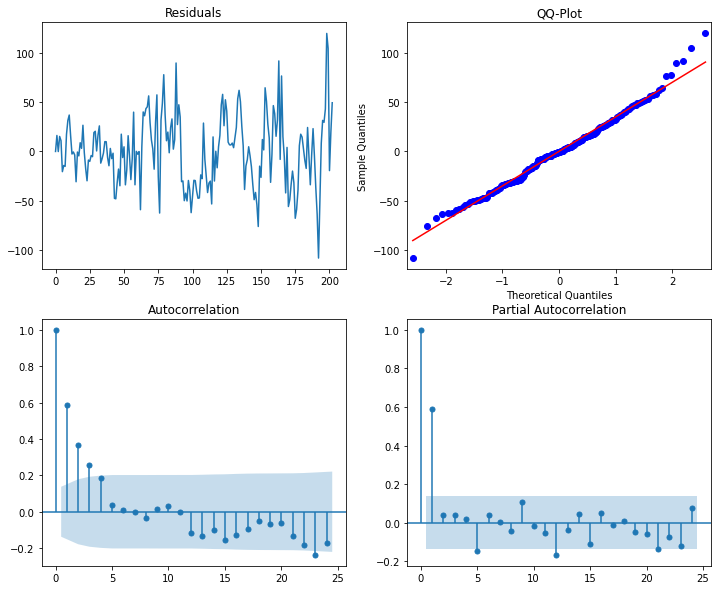

In [14]:
plot_diag(lr, X.iloc[:, 1:], y)